### Data generator

In [15]:
def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21, 1)

### Activation function

In [16]:
import numpy as np

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0-x)

def leakyrelu(x, alpha):
    return np.maximum(alpha*x, x)

def derivative_leakyrelu(x, alpha):
    return np.where(x>0, 1, alpha)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def derivative_tanh(x):
    return 1 - x**2

### Loss function

In [17]:
def MSE(y, pred_y):
    return np.mean((y-pred_y)**2)

def derivative_MSE(y, pred_y):
    return 2 * (pred_y-y) / y.shape[0]

### Layer

In [18]:
class layer:
    def __init__(self, input_dim, output_dim, act_func):
        np.random.seed(311552007)
        self.w = np.random.rand(input_dim, output_dim)
        self.act_func = act_func
        
    def forward(self, x):
        self.input = x
        self.output = x @ self.w
        if self.act_func == "sigmoid":
            self.act_out = sigmoid(self.output)
        elif self.act_func == "leakyrelu":
            self.act_out = leakyrelu(self.output, 0.2)
        elif self.act_func == "tanh":
            self.act_out = tanh(self.output)
        elif self.act_func == "none":
            self.act_out = self.output
            
        return self.act_out
        
    def backward(self, grad_loss):
        if self.act_func == "sigmoid":
            tmp = derivative_sigmoid(self.act_out) * grad_loss
        elif self.act_func == "leakyrelu":
            tmp = derivative_leakyrelu(self.output, 0.2) * grad_loss
        elif self.act_func == "tanh":
            tmp = derivative_tanh(self.act_out) * grad_loss
        elif self.act_func == "none":
            tmp = grad_loss
        self.grad = self.input.T @ tmp
        return tmp @ self.w.T
        

### Neural network

In [19]:
class nn:
    def __init__(self, num_layer=2, input_dim=2, output_dim=1, hidden_dim=[10, 10], act_func='sigmoid'):
        size = list(map(int, str(input_dim)))+hidden_dim+list(map(int, str(output_dim)))
        self.layers = [layer(size[i], size[i+1], act_func) for i in range(num_layer+1)]
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
        return x

    def backward(self, grad_loss):
        for i in range(len(self.layers))[::-1]:
            grad_loss = self.layers[i].backward(grad_loss)
            
    def parameters(self):
        return self.layers

### Optimizer

In [20]:
class optim:
    def __init__(self, parameters, args):
        self.optimizer = args.optimizer
        self.layers = parameters
        if self.optimizer == 'gd':
            self.lr = args.lr
        elif self.optimizer == 'adam':
            self.beta1 = args.beta1
            self.beta2 = args.beta2
            self.eps = args.eps
            self.lr = args.lr
            self.m = [0 for i in range(len(self.layers))]
            self.v = [0 for i in range(len(self.layers))]
            self.t = 1
        
    def step(self):
        for i in range(len(self.layers)):
            if self.optimizer == 'gd':
                self.layers[i].w -= self.layers[i].grad * self.lr
            elif self.optimizer == 'adam':
                self.m[i] = (self.beta1 * self.m[i] + (1 - self.beta1) * self.layers[i].grad)
                self.v[i] = (self.beta2 * self.v[i] + (1 - self.beta2) * (self.layers[i].grad**2))
                m_hat = self.m[i] / (1-self.beta1**self.t)
                v_hat = self.v[i] / (1-self.beta2**self.t)
                self.layers[i].w -= self.lr * (m_hat / (self.eps + np.sqrt(v_hat)))
        if self.optimizer == 'adam':
            self.t += 1

In [21]:
def train(model, x, y, args):
    losses = []
    epochs = []
    optimizer = optim(model.parameters(), args)
    for epoch in range(args.epochs):
        pred_y = model.forward(x)
        loss = MSE(y, pred_y)
        model.backward(derivative_MSE(y, pred_y))
        optimizer.step()
        
        losses.append(loss)
        epochs.append(epoch)
        
        if loss <= args.threshold:
            print('epoch {} loss : {:.5f}'.format(epoch, loss))
            print('Early terminate!')
            break
        elif epoch % args.interval == 0:
            print('epoch {} loss : {:.5f}'.format(epoch, loss))

    return losses, epochs
            
def test(model, x, y):
    pred_y = model.forward(x)
    acc = (((pred_y>=0.5)==y).sum() * 100) / y.shape[0]
    for i in range(y.shape[0]):
        print('Case {}\t| Ground truth: {} | Prediction: {:.5f}'.format(i, y[i].item(), pred_y[i].item()))
    print('accuracy: {:.2f}%'.format(acc))
    return (pred_y>=0.5)

### Training

In [28]:
import argparse

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default='1e-2', type=float, help='learning rate')
    parser.add_argument('--act', default='sigmoid', type=str, help='activation function')
    parser.add_argument('--epochs', default='1000000', type=int, help='maximum epochs')
    parser.add_argument('--interval', default='5000', type=int, help='print interval')
    parser.add_argument('--threshold', default='2e-2', type=float, help='early terminate threshold')
    parser.add_argument('--optimizer', default='gd', type=str, help='optimizer')
    parser.add_argument('--beta1', default='0.9', type=float, help='adam optimizer args')
    parser.add_argument('--beta2', default='0.999', type=float, help='adam optimizer args')
    parser.add_argument('--eps', default='1e-8', type=float, help='adam optimizer args')
    
    return parser


parser = get_parser()
args = []
args.append(parser.parse_args(args=['--lr', '1e-1', '--act', 'sigmoid', '--epochs', '1000000', '--interval', '5000', '--threshold', '2e-2', '--optimizer', 'gd', '--beta1', '0.9', '--beta2', '0.999', '--eps', '1e-8']))
x, y = generate_XOR_easy()

models = []
losses, epochs = [], []
for i in range(len(args)):
    print("Start training model " + str(i+1) + "...")
    models.append(nn(act_func=args[i].act))
    loss, epoch = train(models[i], x, y, args[i])
    losses.append(loss)
    epochs.append(epoch)
    print("--------------------------------------")

Start training model 1...
epoch 0 loss : 0.51858
epoch 5000 loss : 0.24943
epoch 10000 loss : 0.24928
epoch 15000 loss : 0.24905
epoch 20000 loss : 0.24853
epoch 25000 loss : 0.24674
epoch 30000 loss : 0.23655
epoch 35000 loss : 0.17673
epoch 40000 loss : 0.06321
epoch 45000 loss : 0.03182
epoch 48292 loss : 0.02000
Early terminate!
--------------------------------------


### Testing

In [29]:
predicts = []

for i in range(len(args)):
    print("Start testing model " + str(i+1) + "...")
    predicts.append(test(models[i], x, y))
    print("--------------------------------------")

Start testing model 1...
Case 0	| Ground truth: 0 | Prediction: 0.00089
Case 1	| Ground truth: 1 | Prediction: 0.99890
Case 2	| Ground truth: 0 | Prediction: 0.00475
Case 3	| Ground truth: 1 | Prediction: 0.99835
Case 4	| Ground truth: 0 | Prediction: 0.03319
Case 5	| Ground truth: 1 | Prediction: 0.99612
Case 6	| Ground truth: 0 | Prediction: 0.13484
Case 7	| Ground truth: 1 | Prediction: 0.97475
Case 8	| Ground truth: 0 | Prediction: 0.24225
Case 9	| Ground truth: 1 | Prediction: 0.64742
Case 10	| Ground truth: 0 | Prediction: 0.25025
Case 11	| Ground truth: 0 | Prediction: 0.18424
Case 12	| Ground truth: 1 | Prediction: 0.67895
Case 13	| Ground truth: 0 | Prediction: 0.10928
Case 14	| Ground truth: 1 | Prediction: 0.97784
Case 15	| Ground truth: 0 | Prediction: 0.05872
Case 16	| Ground truth: 1 | Prediction: 0.99339
Case 17	| Ground truth: 0 | Prediction: 0.03154
Case 18	| Ground truth: 1 | Prediction: 0.99430
Case 19	| Ground truth: 0 | Prediction: 0.01792
Case 20	| Ground truth: 1

In [30]:
def learning_curve(losses, epochs):
    import matplotlib.pyplot as plt
    plt.subplots(1)
    plt.title('Learning curve', fontsize=32)
    for i in range(len(losses)):
        plt.plot(epochs[i], losses[i])
    plt.xlabel("Epochs"), plt.ylabel("Loss")
    plt.legend(['GD'], loc='best')
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

In [31]:
def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    plt.subplot(1,2,1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    plt.subplot(1,2,2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
            
    plt.show()

### Compare result

Model 1:


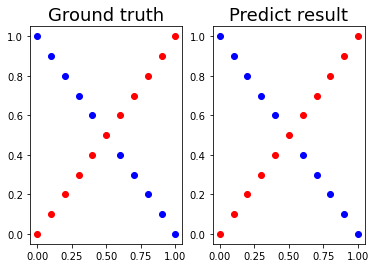

In [32]:
for i in range(len(args)):
    print("Model " + str(i+1) + ":")
    show_result(x, y, predicts[i])


### Learning curve

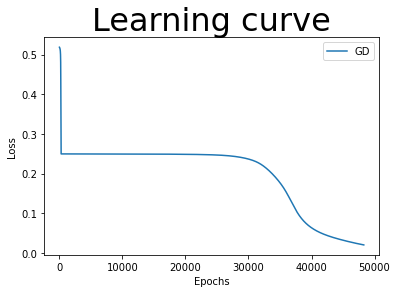

In [33]:
learning_curve(losses, epochs)